# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Задача — выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('real_estate_data.csv', sep ='\t', decimal='.')
pd.set_option('display.max_columns', None)
data.head(20)

In [2]:
data.info()

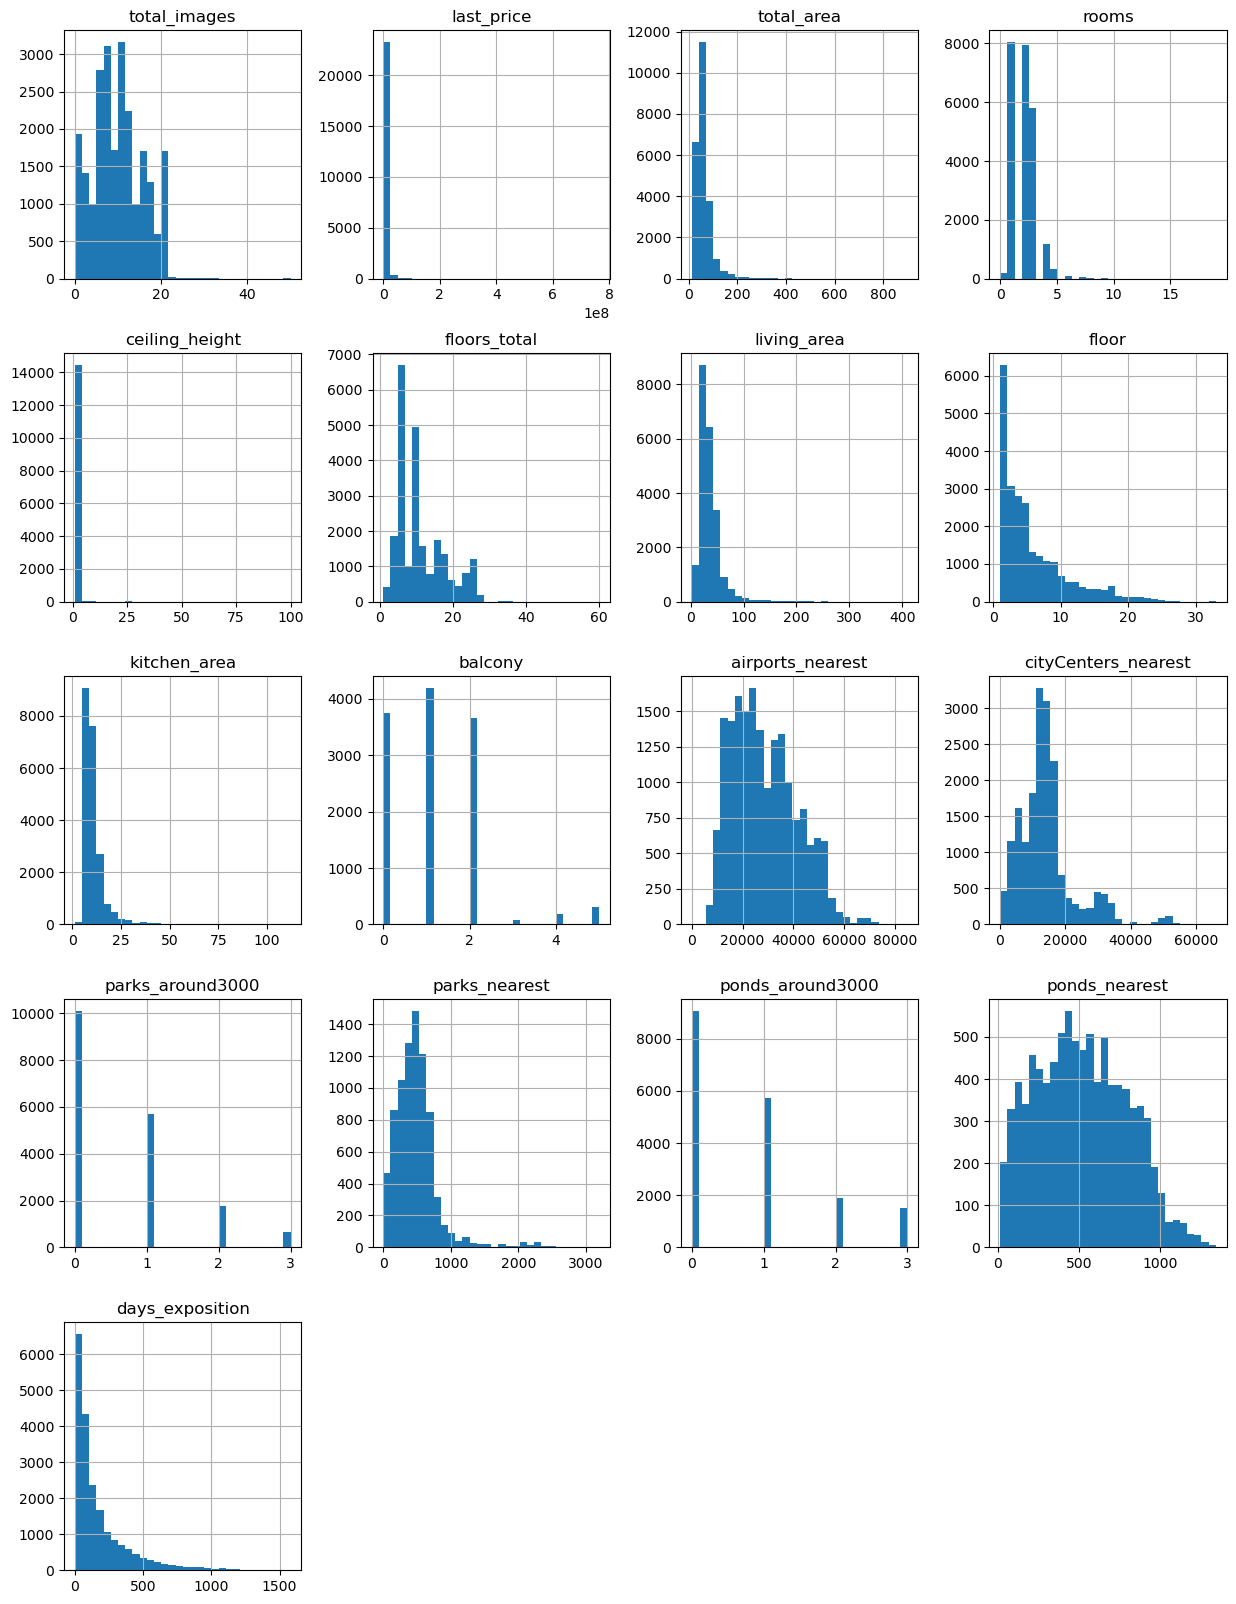

In [3]:
data.hist(figsize=(15, 20), bins=30)

В целом данные распределены согласно распределению Пуассона. Однако на некоторых графиках содержится по несколько пиков или слишком однообразные данные. 

В датасете присутствует много пропусков, типы данных не везде оптимально соответствуют значениям.

### Предобработка данных

#### Заполнение пропусков

In [4]:
data.isna().sum()

##### Балконы

Пропуски в столбце balcony можно заполнить значениями 0, т.к. в пропущенных значениях продавец, скорее всегг, указал, что балконов нет.

In [5]:
data['balcony'] = data['balcony'].fillna(0)
data.isna().sum()

##### Пруды и парки

In [6]:
print(data[['parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']].head(20))
print(data[['parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']].tail(20))

Прослеживается закономерность. Значения одинаково пропущены или равны нулю в столбцах parks_around3000 и parks_nearest, и в ponds_around3000 and ponds_nearest. Проверим это.

In [7]:
data[['parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']].query('(parks_around3000 == 0 or parks_around3000.isnull()) and parks_nearest > 0')

Обратим внимание на столбцы parks_around3000, parks_nearest. Если нет парков в радиусе 3км от квартиры, то и расстояние до ближайшего парка указано либо 0, либо NaN. Значит, можно заменить NaN на значения 0.

Проверим аналогично ponds_around3000 и ponds_nearest.


In [8]:
data[['parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']].query('(ponds_around3000 == 0 or ponds_around3000.isnull()) and ponds_nearest > 0')

Как видно, предположение подтвердилось. Значит и в столбцах ponds_nearest и ponds_around3000 значения NaN можно заменить на 0. 

Скорее всего, данные про парки и водоемы были либо не заполнены вовсе, либо одна из категорий пропущена, т.к. по близости к квартире нет парков / водоёмов.

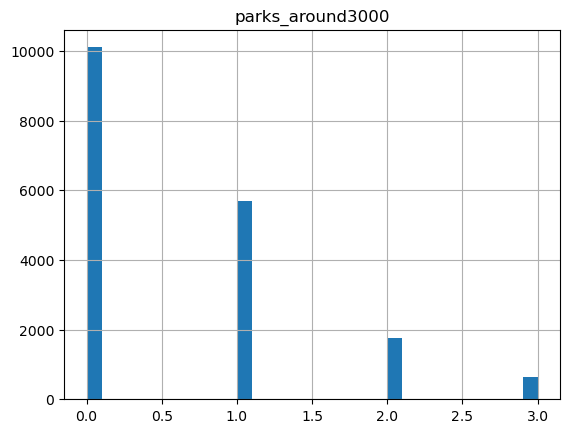

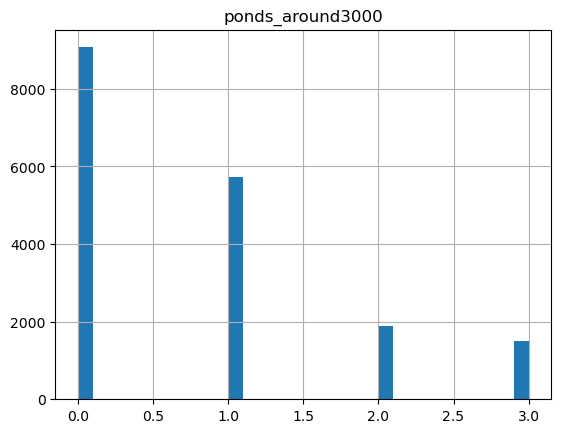

In [9]:
data.hist('parks_around3000', bins=30)
data.hist('ponds_around3000', bins=30)

Заполним пропуски нулями и проверим.

In [10]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data.isna().sum()

##### Высота потолков

Теперь перейдем к пропускам в столбце ceiling_height(высота потолков).

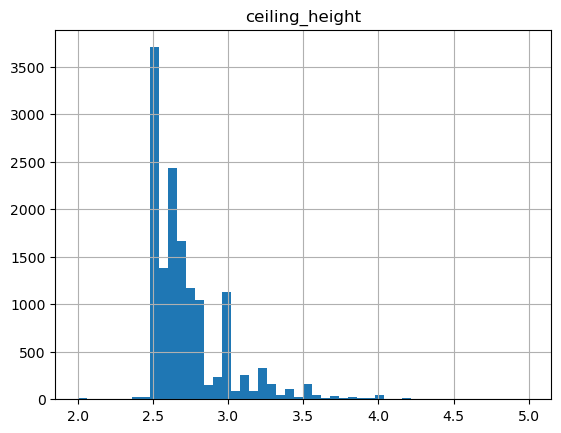

In [11]:
data.hist('ceiling_height', bins=50, range=(2, 5))

На графике видно 2 пика. Первый, самый большой - на высоте потолков 2.5м, второй - на высоте потолков 3м. 

In [12]:
data.corr()['ceiling_height'].sort_values(ascending=False)

Можно предположить, что высота потолков может зависеть от таких параметров, как:
* общая площадь квартиры. Например, в больших квартирах преимущественно могли бы быть и высокие потолки.
* удаленность от центра. Это можно было бы объяснить тем, что в центре более старые дома с определенным типом квартир, а по мере удаления центра мог меняться и тип застройки, а значит и высота потолков.
* населенный пункт. В разных районах могли бы быть разные типы домов, что также могло бы сказаться на медианной высоте потолков.

Проверим эти предположения.

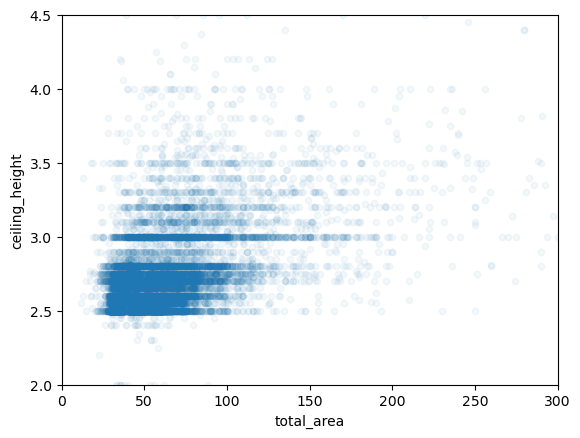

In [13]:
data.plot(x='total_area', y='ceiling_height', kind='scatter', alpha=0.05, xlim=(0, 300), ylim=(2, 4.5))

Исходя из полученного графика, нельзя сказать о зависимости между площадью квартиры и высотой потолков. Большинство значений находятся в области от 30 до 100 кв.м., а высота от 2.5м до 3, с "пробелом" в области 2.8-2.9м

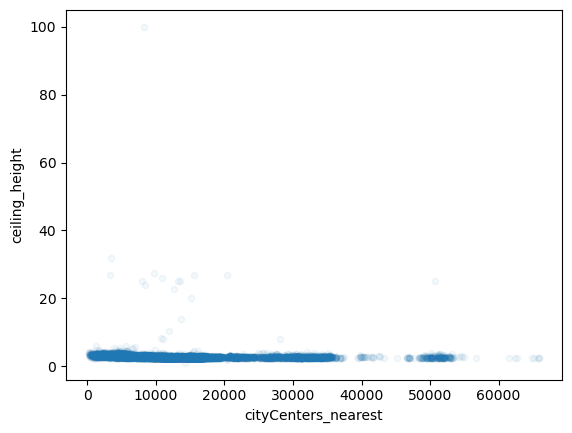

In [14]:
data.plot(x='cityCenters_nearest', y='ceiling_height', kind='scatter', alpha=0.05)

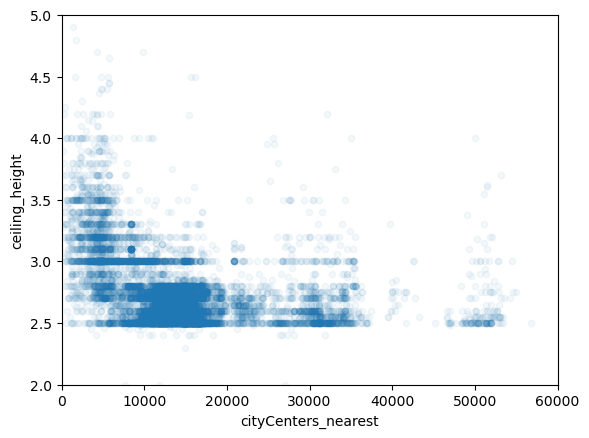

In [15]:
data.plot(x='cityCenters_nearest', y='ceiling_height', kind='scatter', alpha=0.05, xlim=(0, 60000), ylim=(2, 5))

Получив точечную диаграмму, где по оси абсцисс -расстояние до центра, а по оси ординат - высота потолков, можно заметить, что близко к центру находятся квартиры с более высокими потолками, нежели вдали от центра. Рассмотрим подробнее.

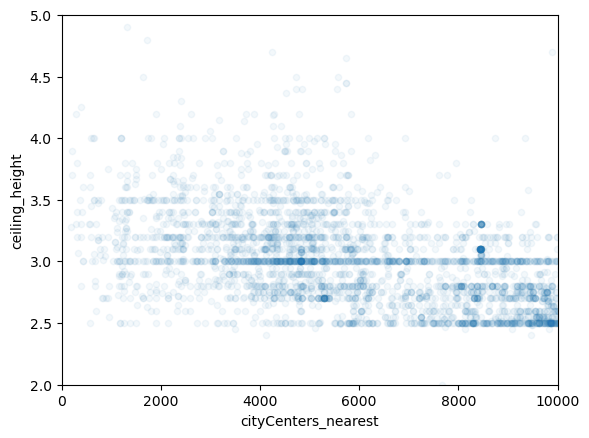

In [16]:
data.plot(x='cityCenters_nearest', y='ceiling_height', kind='scatter', alpha=0.05, xlim=(0, 10000), ylim=(2, 5))

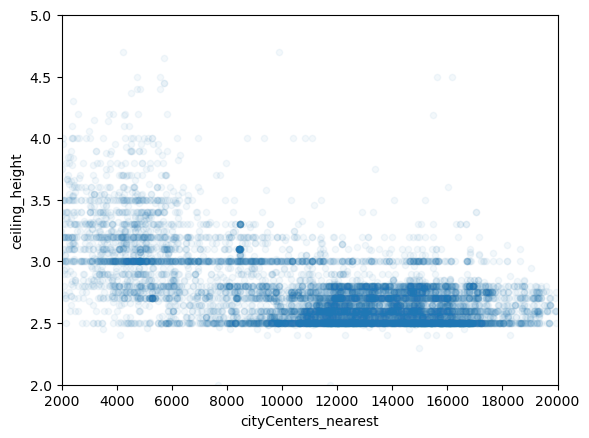

In [17]:
data.plot(x='cityCenters_nearest', y='ceiling_height', kind='scatter', alpha=0.05, xlim=(2000, 20000), ylim=(2, 5))

Посчитаем медианы для всего столбца ceiling_height и отдельно, разбив его на 2 группы по границе расстояния от центра 7000м, т.к. около 7000м резко уменьшается количество квартир с высокими потолками.

In [18]:
data['ceiling_height'].median()

In [19]:
data.query('cityCenters_nearest < 7000')['ceiling_height'].median()

In [20]:
data.query('cityCenters_nearest >= 7000')['ceiling_height'].median()

Проверим медианную высоту потолков в каждом населенном пункте.

In [21]:
data_locality_name = data.pivot_table(index='locality_name', values='ceiling_height', aggfunc=['median', 'mean', 'count'])
data_locality_name.columns=['median', 'mean', 'count']
data_locality_name.sort_values(by='count', ascending=False).head(20)

Как видно, в населенных пунктах довольно маленькая выборка объявлений, а также медианная высота не сильно отличается. Поэтому заполнить пропуски с помощью данных о населенных пунктах не получится.

Вернемся к зависимости высоты потолков от расстояния до центра.

Стоит отметить, что в датасете присутствуют значения с высотой потолков менее 2.5м, что является аномально низким значением (т.к. 2.5м - минимальная высота потолков для жилых помещений в России), а также квартиры с высотой потолков более 4м. Посчитаем количество таких квартир. Позже вернемся к ним.

In [22]:
print('Квартир с потолком ниже 2.5м:', data.query('ceiling_height < 2.5')['ceiling_height'].count())
print('Квартир с потолком выше 4м:', data.query('ceiling_height > 4')['ceiling_height'].count())

Теперь заполним пропуски, исходя из вышеописанного разделения (до 7000м - одна группа, более 7000 - вторая)

In [23]:
data.loc[(data['cityCenters_nearest'] < 7000) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
data.loc[(data['cityCenters_nearest'] < 7000), 'ceiling_height'].median()

In [24]:
data.loc[(data['cityCenters_nearest'] >= 7000) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
data.loc[(data['cityCenters_nearest'] >= 7000), 'ceiling_height'].median()

In [25]:
data.isna().sum()

##### Всего этажей в доме

Теперь перейдем к столбцу с общей этажностью домов (floors_total).

In [26]:
data[['floor', 'floors_total']].loc[data['floors_total'].isna()]

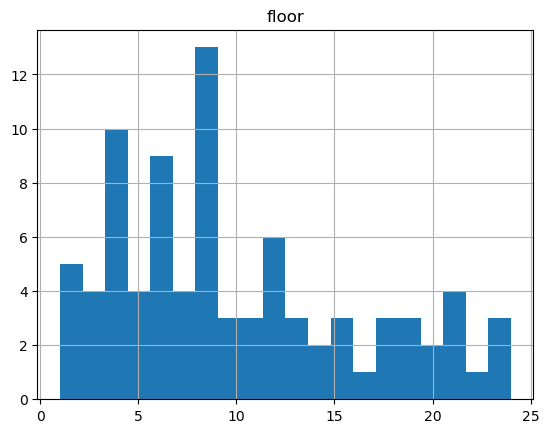

In [27]:
data[['floor', 'floors_total']].loc[data['floors_total'].isna()].hist('floor', bins=20)

Пропущенных значений в столбце floors_total - 86. Взаимосвязи с пропущенным этажом квартиры нет, а также с этажом сдаваемой квартиры. К тому же, группа очень мала. Данные пропуски нельзя заполнить.

Пропуски в столбце locality_name не получится заполнить, к тому же там очень мало значений.

##### Обратим внимание на площадь кухни и жилую

In [28]:
data.query('living_area.isna()')[['living_area', 'kitchen_area']].head(10)

In [29]:
data.query('living_area.isna()')[['living_area', 'kitchen_area']].tail(10)

In [30]:
data.query('not(living_area.isna()) and kitchen_area.isna()')[['living_area', 'kitchen_area']]

Много случаев, где пропущены одновременно площадь жилая и кухни, однако закономерности в этом нет. Те и другие значения также встречаются пропущенными по отдельности.

Пропуски в этих данных заполним, рассчитав медианные значения по количеству комнат в квартире.

In [31]:
data['rooms'].value_counts()

In [32]:
data.query('rooms == 0')[['rooms', 'is_apartment', 'studio', 'open_plan']]

Как видно, не все квартиры с числом комнат, равным 0, являются студиями. Видна закономерность. Квариты с 0 комнат либо студии, либо открытой планировки. Проверим это.

In [33]:
data.query('rooms == 0 and studio == True and open_plan==True')[['rooms', 'is_apartment', 'studio', 'open_plan']]

In [34]:
print('Медиана жилой площади:', data.query('rooms == 0 and studio == True')['living_area'].median())
print('Медиана площади кухни:', data.query('rooms == 0 and studio == True')['kitchen_area'].median())

In [35]:
print('Медиана жилой площади:', data.query('rooms == 0 and open_plan == True')['living_area'].median())
print('Медиана площади кухни:', data.query('rooms == 0 and open_plan == True')['kitchen_area'].median())

Медианные значения совпадают. Значит можем перейти к заполнению пропусков по количеству комнат.

In [36]:
for i in data['rooms'].unique():
    data.loc[(data['rooms'] == i) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == i), 'living_area'].median()
    print(f'Медиана для квартир с {i} комнат:', data.loc[(data['rooms'] == i), 'living_area'].median())


Аналогично заполним кухонные площади.

In [37]:
for i in data['rooms'].unique():
    data.loc[(data['rooms'] == i) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['rooms'] == i), 'kitchen_area'].median()
    print(f'Медиана для кухонь в квартирах с {i} комнат:', data.loc[(data['rooms'] == i), 'kitchen_area'].median())

In [38]:
data.isna().sum()

По максимуму заполнили пропуски

#### Типы данных в столбцах

In [39]:
data.info()

In [40]:
data

В изменении типа данных нуждаются следующие столбцы: last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest, days_exposition, parks_around3000, ponds_around3000  на int, т.к. в них приведены целочисленные значения (либо расстояние в метрах, либо количественные значения). Столбец first_dat_exposition нужно заменить на datetime,  is_apartment на bool.
В некоторых столбцах потребуется заменить значения NaN на другие, чтобы выполнить преобразование.

In [41]:
data['last_price'] = data['last_price'].astype('int')

Заменим на 0 значения NaN в столбцах.

In [42]:
data['floors_total'] = data['floors_total'].fillna(0)
data['floors_total'] = data['floors_total'].astype('int')

In [43]:
data['balcony'] = data['balcony'].astype('int')

In [44]:
data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['airports_nearest'] = data['airports_nearest'].astype('int')

In [45]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int')

In [46]:
data['parks_nearest'] = data['parks_nearest'].astype('int')

In [47]:
data['ponds_nearest'] = data['ponds_nearest'].astype('int')

Посчитаем кол-во записей, равных 0 в столбце days_exposition, это понадобится в пункте 4.2

In [48]:
data.query('days_exposition == 0')['days_exposition'].count()

In [49]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition'] = data['first_day_exposition'].dt.round('1D')

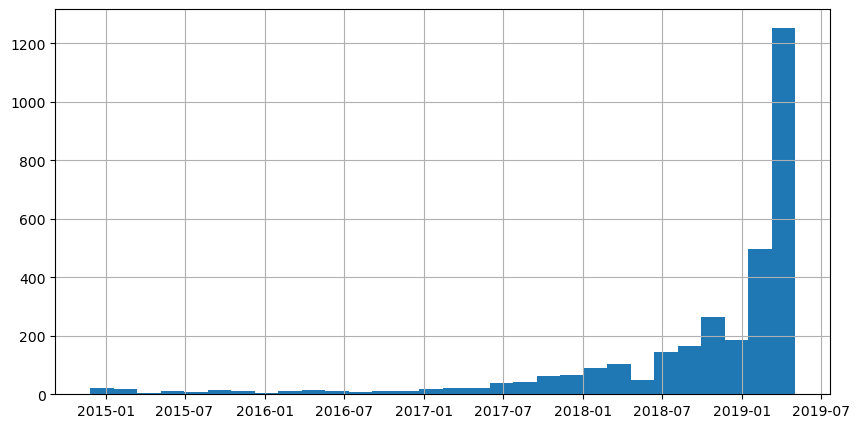

In [50]:
data.query('days_exposition.isna()')['first_day_exposition'].hist(bins=30, figsize=(10, 5))

По распределению пропусков видно, что число пропусков плавно растет, начиная с 2017 года, а подавляющее большинство всех пропусков оставлены весной 2019 года. Это может быть связано с ошибками в выгрузке данных. Такие пропуски лучше не заполнять.

In [51]:
#data['days_exposition'] = data['days_exposition'].fillna(0)
#data['days_exposition'] = data['days_exposition'].astype('int')

In [52]:
data['parks_around3000'] = data['parks_around3000'].astype('int')

In [53]:
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

In [54]:
data['is_apartment'] = data['is_apartment'].astype('bool')

In [55]:
data.info()

In [56]:
data.isna().sum()

Преобразуем столбец first_day_exposition в тип datetime

#### Поиск дубликатов

In [57]:
data.head(1)

Проверим данные на наличие явных дубликатов

In [58]:
data.duplicated().sum()

Перейдем к неявным дубликатам в названиях населенных пунктов.

In [59]:
print(len(data['locality_name'].unique()))
data['locality_name'].unique()

In [60]:
data['locality_name'] = data['locality_name'].fillna('неизвестно')

In [61]:
def new_names(row):
    name = row['locality_name']
    name = name.split(sep=' ')[-1]
    if 'ё' in name:
        name = name.replace('ё', 'е')
    return name

data['short_locality_name'] = data.apply(new_names, axis=1)

In [62]:
print(len(data['short_locality_name'].unique()))
data['short_locality_name'].sort_values().unique()

In [63]:
data.loc[data['short_locality_name'] == 'километр', 'short_locality_name'] = 'Платформа 69-й км'
data['short_locality_name'].sort_values().unique()

In [64]:
data

#### Устранение выбивающихся значений

Рассмотрим столбцы, в которых могут быть аномалии.

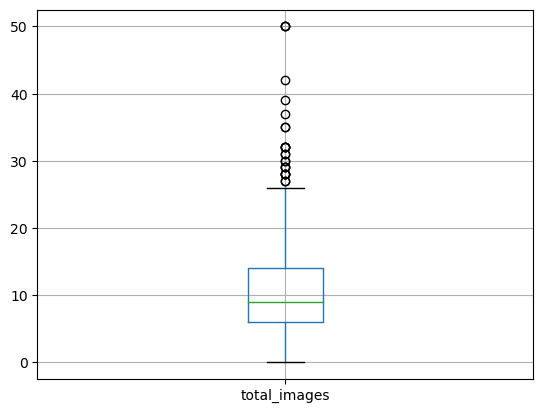

In [65]:
data.boxplot('total_images')
data['total_images'].value_counts()

Поставим ограничение в 20 фотографий. Т.к. количество фотографий более 20 в объявлении встречается очень редко - скорее всего это ошибка в данных.

In [66]:
data_filtered = data.copy()
data_filtered['total_images'].count()

In [67]:
data_filtered = data_filtered.query('total_images <= 20')
data_filtered['total_images'].count()

Теперь в столбце ceiling_height значения больше 20м поделим на 10, т.к., скорее всего, это ошибка в данных.

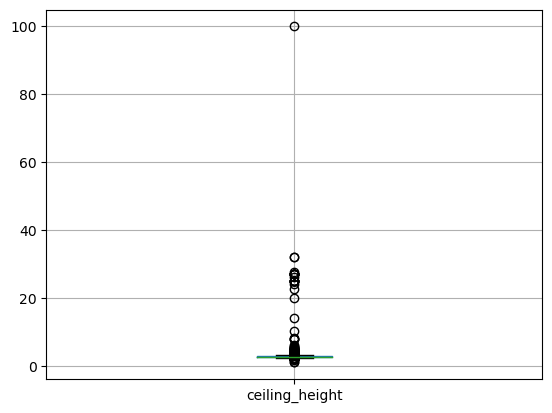

In [68]:
data.boxplot('ceiling_height')

In [69]:
data_filtered.query('ceiling_height > 20')['ceiling_height'].value_counts()

In [70]:
data_filtered['ceiling_height'] = data_filtered['ceiling_height'].replace({
    25.0: 2.5,
    27.0: 2.7,
    32.0: 3.2,
    24.0: 2.4,
    26.0: 2.6,
    20.0: 2.0,
    27.5: 2.75
})

In [71]:
data_filtered = data_filtered.query('ceiling_height != 100')
data_filtered['total_images'].count()

Избавимся от аномалий, где сумма площадей кухни и жилой части квартиры больше общей площади квартиры.

In [73]:
data_filtered = data_filtered.query('living_area + kitchen_area <= total_area')
data_filtered['total_images'].count()

Избавимся от всех нулей в столбце floors_total. Ранее значения NaN мы заменили на 0.

In [74]:
data_filtered = data_filtered.query('floors_total > 0')
data_filtered['total_images'].count()

Проверим, есть записи, в которых этаж квартиры выше максимального в доме.

In [75]:
#data_filtered = data_filtered.query('floor >= floors_total')
data_filtered.loc[(data_filtered['floor'] > data_filtered['floors_total']) & (data_filtered['floors_total'] != 0)]

Проверим на наличие аномалий столбцы: balcony, parks_around3000, ponds_around3000.

In [76]:
data_filtered['balcony'].value_counts()

In [77]:
data_filtered['parks_around3000'].value_counts()

In [78]:
data_filtered['ponds_around3000'].value_counts()

In [79]:
data_filtered['total_images'].count()

Уберем из датафрейма все значения, в которых расстояние до центра города равно нулю (ранее мы заменили NaN на 0).

In [80]:
data_filtered.query('cityCenters_nearest == 0')['total_images'].count()

Таких значений очень много, поэтому от идеи избавиться от них стоит отказаться. Будем помнить при анализе, что много нулевых значений.

In [81]:
data.head(1)

Теперь уберем из датафрейма все значения, не попадающие в "нормальные". (срезаем по 0.5% краевых значений в датафрейме)

In [82]:
columns_to_filter = [
    'last_price',
    'total_area',
    'living_area',
    'kitchen_area',
    'airports_nearest',
    'cityCenters_nearest',
    'days_exposition',
]

for column in columns_to_filter:
    data_filtered = data_filtered[(data_filtered[column].isna()) | \
                                  ((data_filtered[column] <= data_filtered[column].quantile(0.995)) & \
                                   (data_filtered[column] >= data_filtered[column].quantile(0.005)))]
    
data_filtered['total_images'].count()

В данном параграфе мы подготовили данные к дальнейшему анализу:
* заполнили пропуски, где это было возможно;
* изменили типы данных;
* избавились от дубликатов;
* избавились от выбросов.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим столбец с ценой одного квадратного метра в каждом случае.

In [83]:
data_filtered['meter_price'] = round(data_filtered['last_price'] / data_filtered['total_area'], 2)
data_filtered.head(5)

Добавим столбец, указывающий на день недели публикации.

In [84]:
data_filtered['week_day_exposition'] = data_filtered['first_day_exposition'].dt.weekday
data_filtered.head(5)

Добавим столбец, указывающий на месяц публикации объявления.

In [85]:
data_filtered['month_exposition'] = data_filtered['first_day_exposition'].dt.month
data_filtered.head(5)

Добавим столбец с годом публикации объявления.

In [86]:
data_filtered['year_exposition'] = data_filtered['first_day_exposition'].dt.year
data_filtered.head(5)

Добавим столбец с типом этажа квартиры(первый, последний, другой). Для этого напишем отдельную функцию.

In [87]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data_filtered['floor_type'] = data_filtered.apply(floor_type, axis=1)
data_filtered.head(10)

Добавим столбец с расстоянием до центра города в км.

In [88]:
data_filtered['cityCenters_nearest_km'] = round(data_filtered['cityCenters_nearest'] / 1000).astype('int')
data_filtered.head(5)

В этом параграфе мы добавили 6 новых столбцов в датафрейм, а именно:
* цена квадратного метра;
* день публикации объявления;
* месяц публикации объявления;
* год публикации объявления;
* тип этажа;
* расстояние до центра в км.

Эти данные пригодятся нам для дальнейшего анализа.

### Проведите исследовательский анализ данных

#### Изучим данные в подготовленном датасете.

##### Площадь квартиры

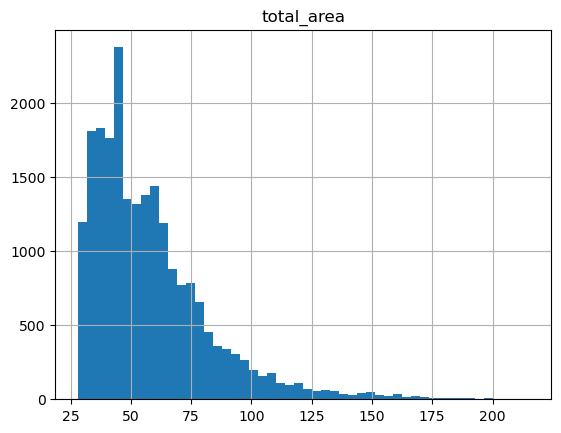

In [89]:
data_filtered.hist('total_area', bins=50)

In [90]:
data_filtered['total_area'].describe()

In [91]:
data_filtered['total_area'].value_counts()

На гистограмме данные расположены характерно распределению Пуассона. Левая граница - 28 кв.м. - наименьшая площадь квартир в данных. Пик около 45 кв.м. Квартир именно с такой площадью больше всего. Плавный спад числа квартир при увеличеннии площади.

##### Жилая площадь

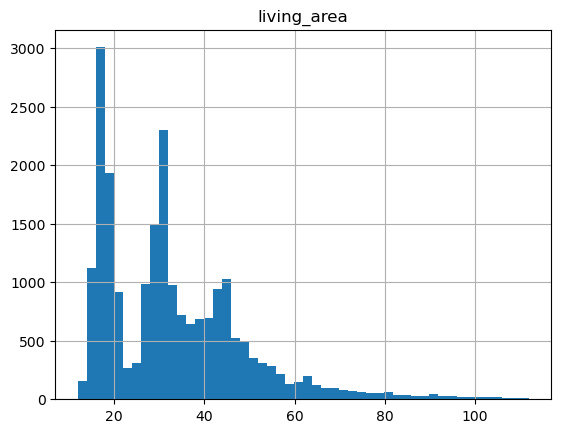

In [92]:
data_filtered.hist('living_area', bins=50)

In [93]:
data_filtered['living_area'].describe()

По гистограмме видно, что данные не соответствуют распределению Пуассона. 3 пика на площади около 17, 30 и 45 кв.м. Это может быть связано с тем, что домов с определенными площадами комнат (а значит и с определенными площадами жилых помещений) строили больше, чем других (например, площадь 20 кв.м. (с комнатой 4*5) может встречаться гораздо чаще, нежели с площадью 22 кв.м. из-за особенностей проектов домов). Таким образом, нельзя сказать, что это аномальные данные.

##### Площадь кухни

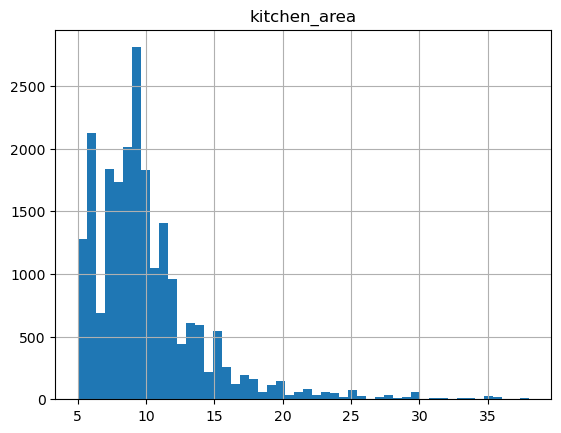

In [94]:
data_filtered.hist('kitchen_area', bins=50)

In [95]:
data_filtered['kitchen_area'].describe()

Распределение данных похоже на Пуассоновское. Однако присутствующие спады и пики, как и в случае с жилой площадью, могут говорить о стандартах застройки, а не аномалиях в данных.

##### Цена объекта

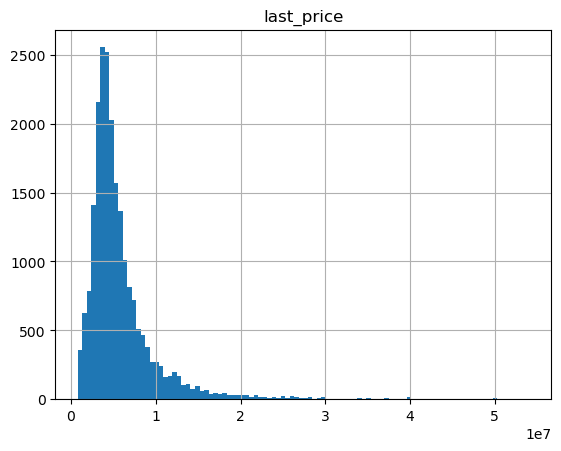

In [96]:
data_filtered.hist('last_price', bins=100)

In [97]:
data_filtered['last_price'].describe()

На гистограмме хараеткрное распределение Пуассона. Пик на цене около 4.5 млн. Плавный спад количества при увеличении цены.

##### Количество комнат

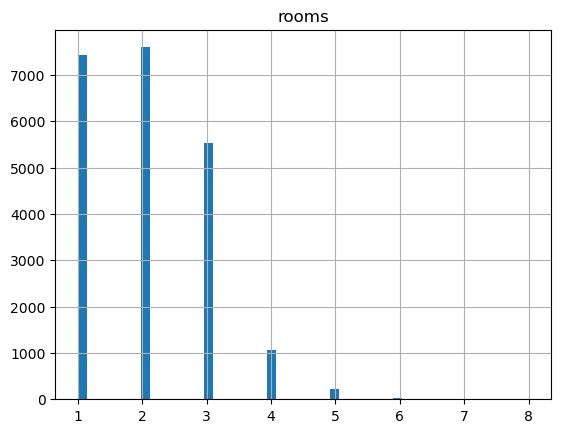

In [98]:
data_filtered.hist('rooms', bins=50)

In [99]:
data_filtered['rooms'].describe()

Исходя из полученной гистограммы, можно сказать, что больше всего продавалось двухкомнатных квартир. Чуть меньше - однокомнатных и трехкомнатных. Значительно меньше четырехкомнатных, мало пятикомнтаных и изредка появлялись шестикомнатные квартиры.

##### Высота потолков

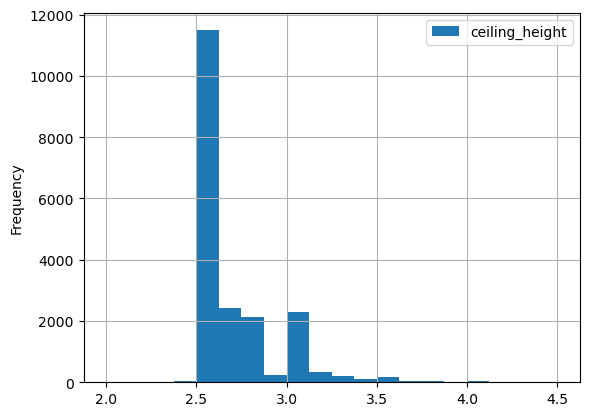

In [100]:
data_filtered.plot(kind='hist', y='ceiling_height', bins=20, range=(2, 4.5), grid=True)

In [101]:
data_filtered['ceiling_height'].describe()

По гистограмме видно 2 пика на высоте потолков около 2.6м и 3м. После них идут достаточно резкие спады. Это может быть связано со стандартами застройки. 

##### Этаж квартиры

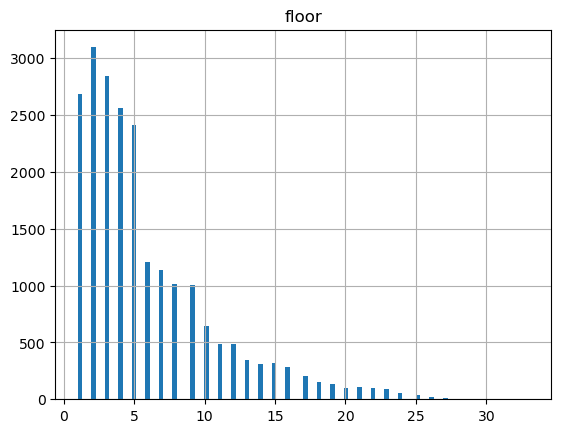

In [102]:
data_filtered.hist('floor', bins=100)

In [103]:
data_filtered['floor'].describe()

На гистограмме этажей - распределение Пуассона. Пик на 2 этаже. Далее плавный спад.

##### Тип этажа квартиры

In [104]:
data_filtered.head()

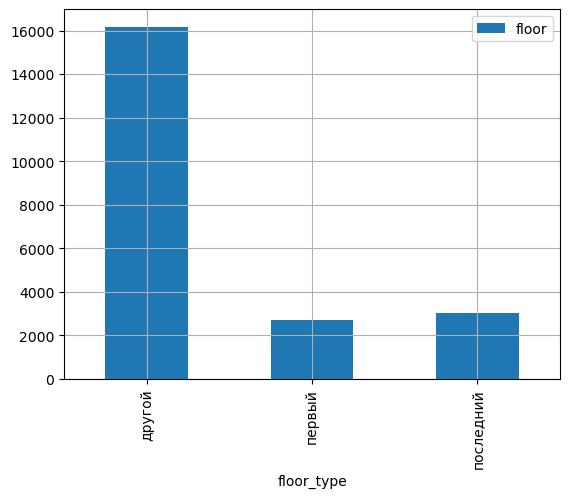

In [105]:
data_filtered.pivot_table(index='floor_type', values='floor', aggfunc='count').plot(kind='bar', grid=True)

Как и следовало ожидать, меньше всего квартир продавалось с первым или последним этажом.

##### Общее количество этажей в доме

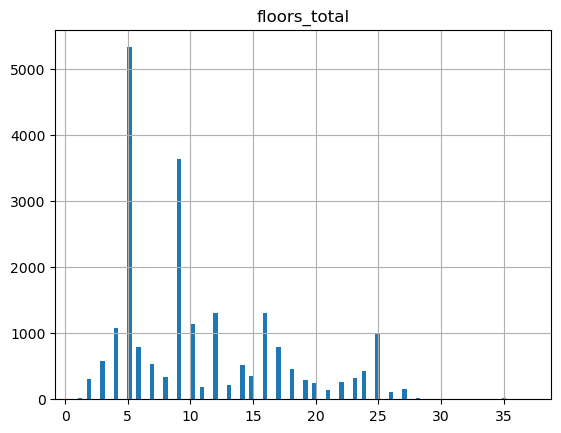

In [106]:
data_filtered.hist('floors_total', bins=100)

Пики видны на 5 и 9 этажах (далее небольшие пики на 12, 16, 25). Это соответствует популярным этажностям домов. 5ти и 9ти  этажные дома - наиболее часто встречающиеся.

##### Расстояние до центра города в метрах

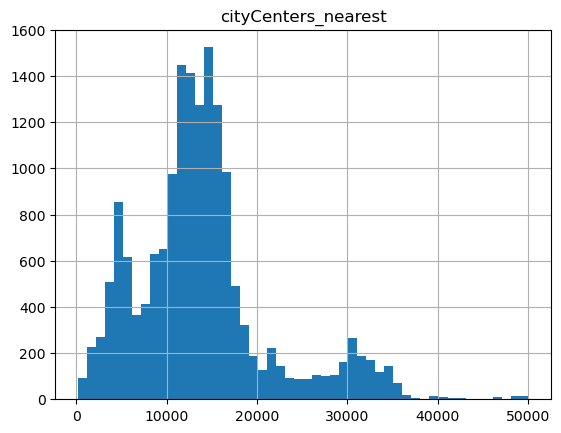

In [107]:
data_filtered.query('cityCenters_nearest != 0').hist('cityCenters_nearest', bins=50)

In [108]:
data_filtered.query('cityCenters_nearest != 0')['cityCenters_nearest'].describe()

Убрав нулевые значения, построили гистограмму. На гистограмме видны пики на расстоянии около 5000м, 13000м и 15000м от центра. Наибольшие на 13 и 15 тыс.м. Это может быть связано с неравномерностью жилой застройки, разной этажностью домов (соответственно разное количество квартир) в разных районах, наличием крупных жилых районов в этих местах.

##### Расстояние до ближайшего аэропорта

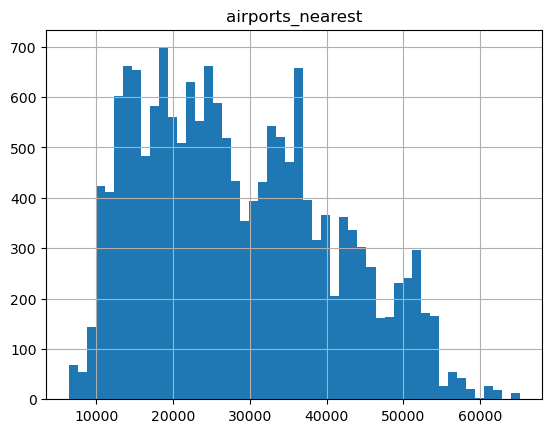

In [109]:
data_filtered.query('airports_nearest != 0').hist('airports_nearest', bins=50)

In [110]:
data_filtered.query('airports_nearest != 0')['airports_nearest'].describe()

По гистограмме можно сказать, что относительно равномерно распределены объявления в зависимости от расстояния до аэропорта. Пики присутствуют, но они не сильно выбиваются из основной массы данных. Очень плавный спад при увеличении расстояния.

##### Расстояние до ближайшего парка

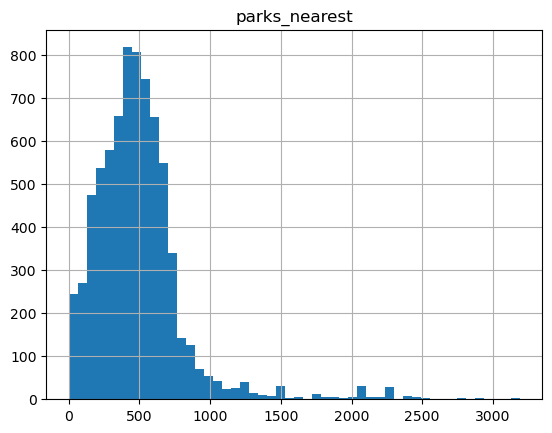

In [111]:
data_filtered.query('parks_nearest != 0').hist('parks_nearest', bins=50)

In [112]:
data_filtered.query('parks_nearest != 0')['parks_nearest'].describe()

Распределение Пуассона. Исключив нулевые значения, аномалий не наблюдается. Пик на расстоянии около 400м до ближайшего парка.

##### День публикации

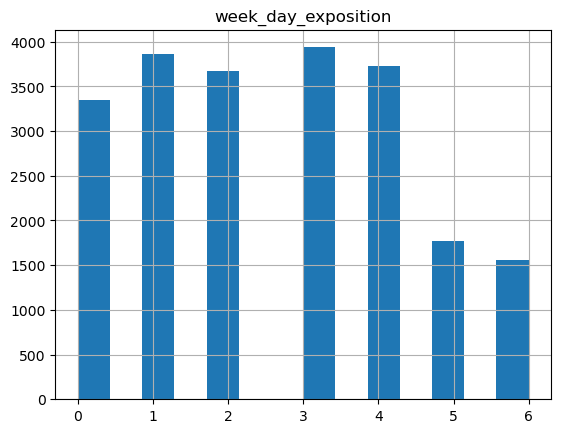

In [113]:
data_filtered.hist('week_day_exposition', bins=14)

Судя по гистограмме, чаще всего выкладывают объявления в будние дни, а именно вторник и четверг. Существенно реже - в выходные.

##### Месяц публикации

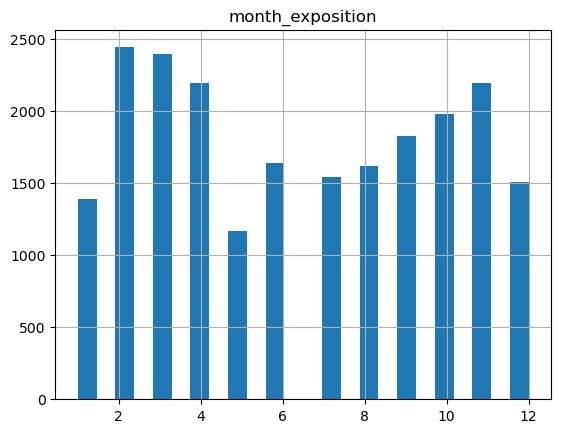

In [114]:
data_filtered.hist('month_exposition', bins=24)

По гистограмме видно, что в феврале чаще всего люди начинают продавать квартиры, затем плавно снижается активность до мая. В июне возрастает и так до пика в ноябре, затем снова спад.

#### Как быстро продаются квартиры

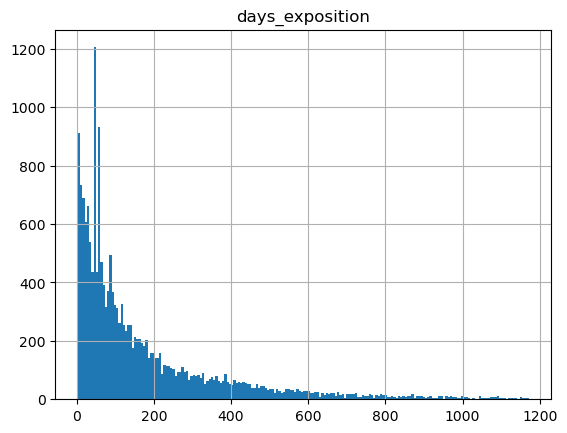

In [115]:
data_filtered.query('days_exposition != 0').hist('days_exposition', bins=200)

In [116]:
data_filtered.query('days_exposition != 0')['days_exposition'].value_counts()

In [117]:
data_filtered.query('days_exposition != 0')['days_exposition'].median()

In [118]:
data_filtered.query('days_exposition != 0')['days_exposition'].mean()

Нулями мы заполняли пропуски в пункте 2.2, поэтому при анализе не будем учитывать их. По гистограмме видно, что подавляющее большинство квартир продается в первые два месяца. Затем, согласно распределению Пуассона, количество проданных падает в зависимости от даты с размещения объявления. Больше всего было продано квартир спустя 1.5 месяца после публикации объявления. Медианное количество дней до продажи - 95 дней. Среднее арифметическое - 174. 
Можно считать, что если квартира продана быстрее, чем за 1.5 месяца - то это быстрые продажи. Сильный спад можно наблюдать уже после 400 дней продажи. Такие продажи можно считать необычно долгими.

#### Факторы, влияющие на цену

Рассмотрим факторы, которые могут влиять на стоимость квартиры.

##### Влияние общей площади

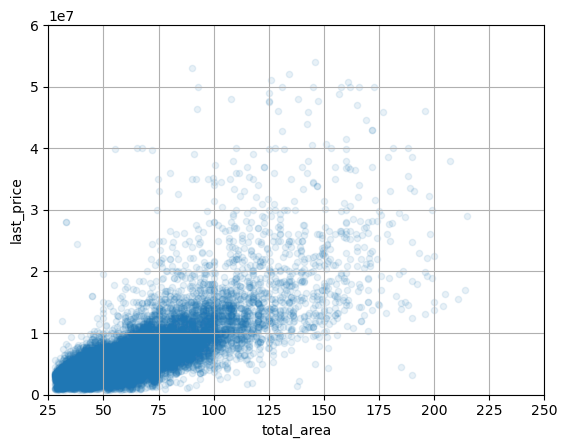

In [119]:
data_filtered.plot(x='total_area', y='last_price', kind='scatter', alpha=0.1, grid=True, xlim=(25, 250), ylim=(0, 60000000))

In [120]:
data_filtered['last_price'].corr(data_filtered['total_area'])

Построив график и вычислив коэффициент корреляции, можно сделать очевидный вывод, что цена сильно зависит от общей площади квартиры. Чем больше квартира - тем дороже будет она.

##### Влияние жилой площади

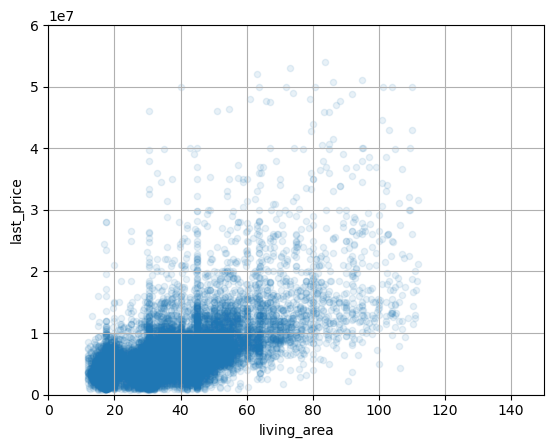

In [121]:
data_filtered.plot(x='living_area', y='last_price', kind='scatter', alpha=0.1, grid=True, xlim=(0, 150), ylim=(0, 60000000))

In [122]:
data_filtered['last_price'].corr(data_filtered['living_area'])

Как видно из графика, зависимость цены от жилой площади тоже довольно сильная, однако меньше, чем в предыдущем пункте.

##### Влияние площади кухни

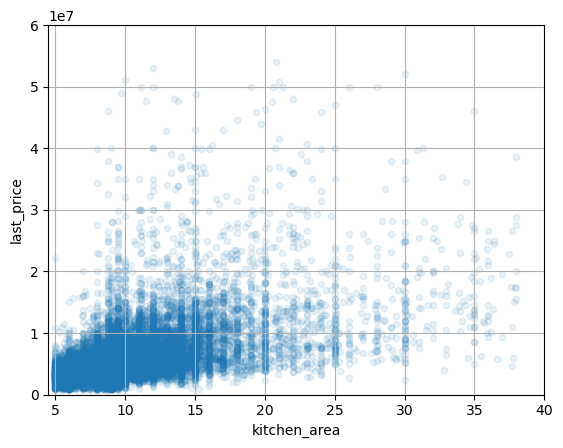

In [123]:
data_filtered.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.1, grid=True, xlim=(4.5, 40), ylim=(0, 60000000))

In [124]:
data_filtered['last_price'].corr(data_filtered['kitchen_area'])

Стоимость квартир растет с увеличением площади кухни. Однако эта зависимость слабее, чем зависимость стоимости от общей и жилой площади.

##### Влияние количества комнат

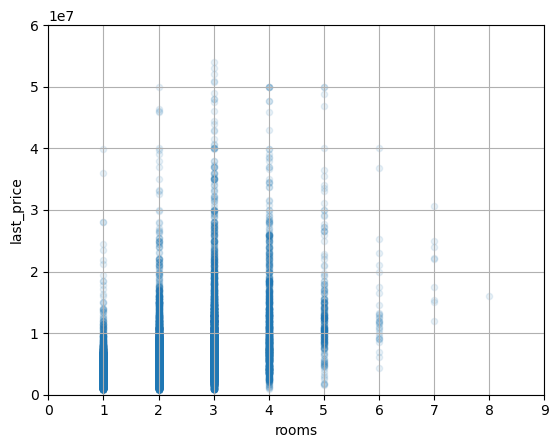

In [125]:
data_filtered.plot(x='rooms', y='last_price', kind='scatter', alpha=0.1, grid=True, xlim=(0, 9), ylim=(0, 60000000))

In [126]:
data_filtered['last_price'].corr(data_filtered['rooms'])

In [127]:
rooms_price = data_filtered.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median'])
rooms_price.columns = ['mean', 'median']
rooms_price

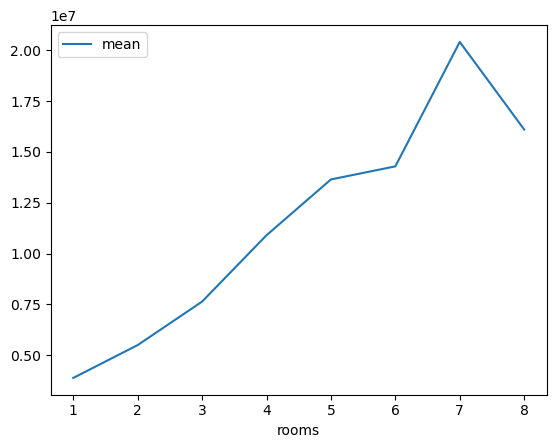

In [128]:
rooms_price.plot(y='mean')

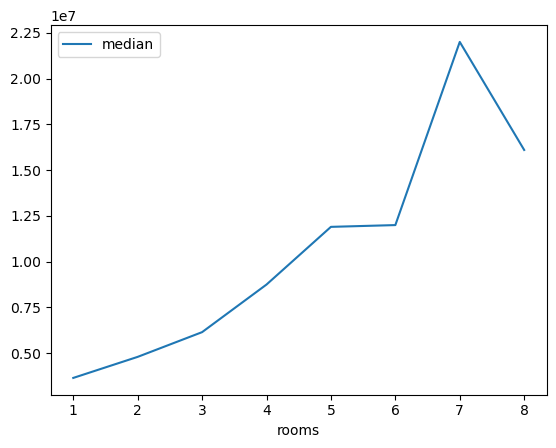

In [129]:
rooms_price.plot(y='median')

In [130]:
data_filtered['rooms'].value_counts()

С количеством комнат растет и цена квартиры. Однако, по диаграмме рассеяния видно, что есть много трехкомнатных квартир, стоимость которых выше, чем в квартирах 4-мя и более комнатами. Аналогично есть много четырехкомнатных квартир, стоимость которых выше некоторых квартир с пятью и более комнатами. Т.к. в выборке мало квартир с 6 комнатами и крайне мало с 7 и 8 комнатами, графики искажаются.

##### Влияние типа этажа

In [131]:
data_filtered.pivot_table(index='floor_type', values='last_price', aggfunc=['mean', 'median'])

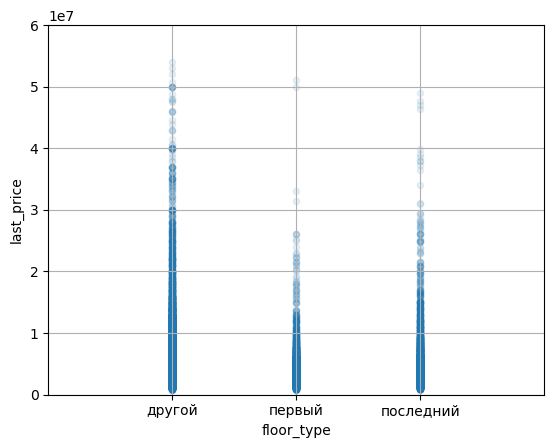

In [132]:
data_filtered.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.1, grid=True, xlim=(-1, 3), ylim=(0, 60000000))

По этому графику можно сказать, что квартиры на первом и последних этажах чаще продаются дешевле, чем квартиры на других этажах. Это связано с очевидными минусами этих этажей (на первом: шум, прохожие; на последнем: высоко подниматься без лифта, коммуникации, протечки).

##### Влияние даты размещения

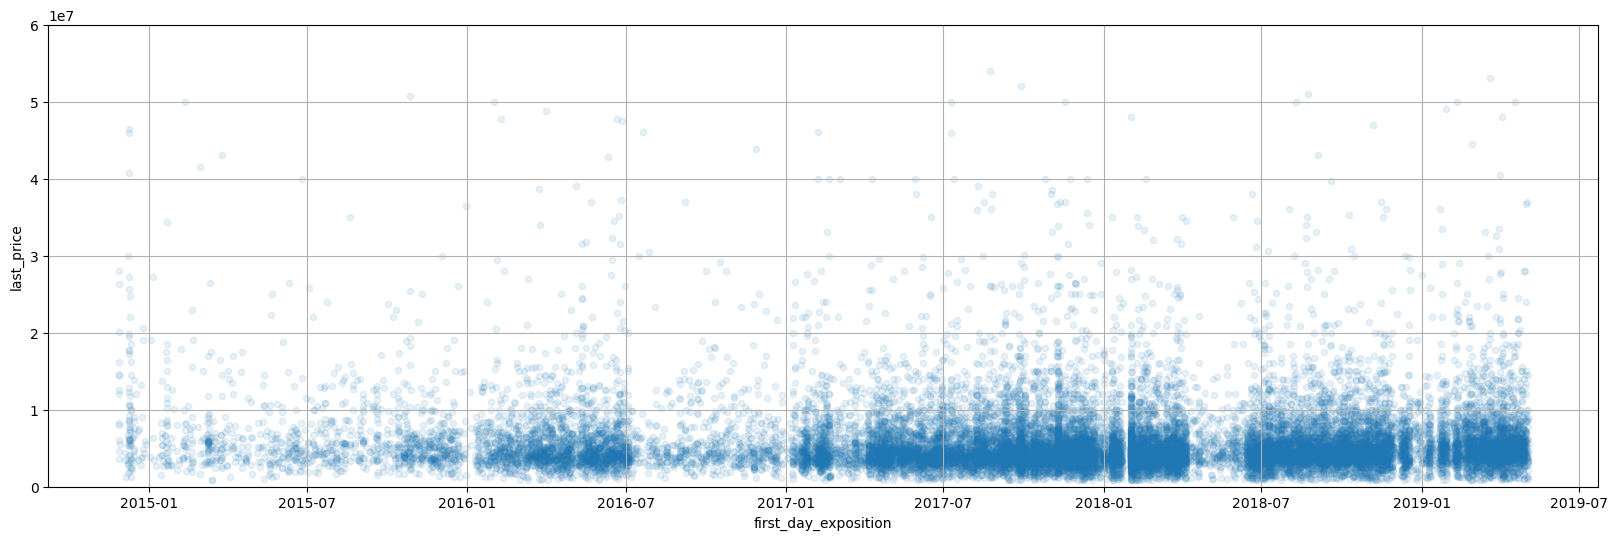

In [133]:
data_filtered.plot(x='first_day_exposition', y='last_price', kind='scatter', alpha=0.1, grid=True, ylim=(0, 60000000), figsize=(20, 6))

По данному графику мы видим, что с каждым годом число продаваемых квартир растет, однако о зависимости цены от даты говорить пока рано.

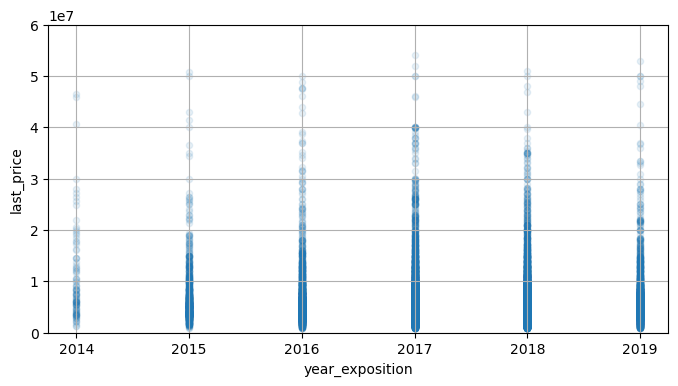

In [134]:
data_filtered.plot(x='year_exposition', y='last_price', kind='scatter', alpha=0.1, grid=True, ylim=(0, 60000000), figsize=(8, 4))

Судя по графику, связь между годом продажи и стоимостью квартиры очень слабая. Возможно, в 2017 году цены чуть поднялись, но потом снова снизились.

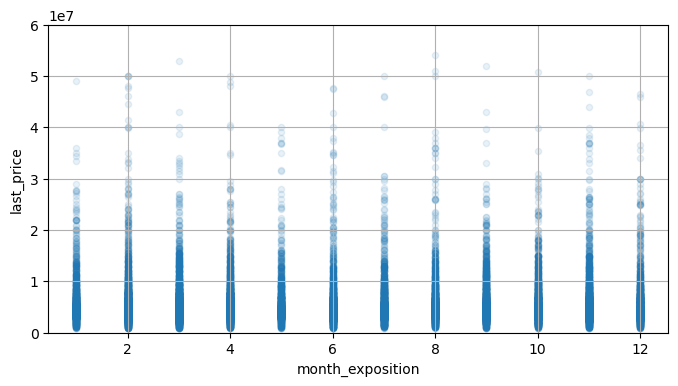

In [135]:
data_filtered.plot(x='month_exposition', y='last_price', kind='scatter', alpha=0.1, grid=True, ylim=(0, 60000000), figsize=(8, 4))

Связь между месяцем публикации и стоимостью квартиры отсутствует. Это неудивительно, т.к. квартиры стоят больших денег и вряд ли есть месяцы, когда спрос на них повышен.

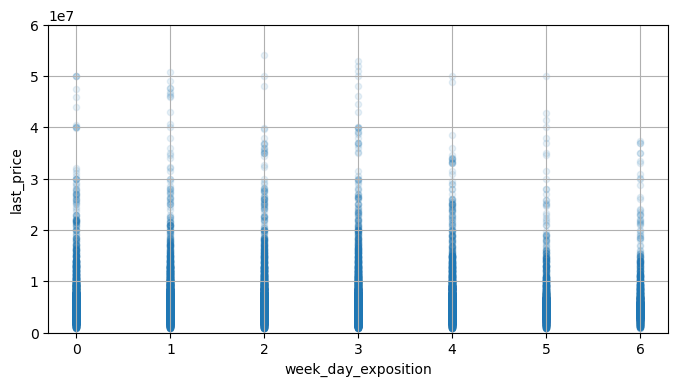

In [136]:
data_filtered.plot(x='week_day_exposition', y='last_price', kind='scatter', alpha=0.1, grid=True, ylim=(0, 60000000), figsize=(8, 4))

Аналогично и с днями недели, они никак не влияют на стоимость квартиры.

#### Средняя цена 1 кв.м.

Посчитаем среднюю цену одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений.

In [137]:
data_filtered.head(5)

In [138]:
data_locality_count = data_filtered.pivot_table(index='locality_name', values='meter_price', aggfunc='count').sort_values(by='meter_price', ascending=False)
data_locality_count.columns = ['count']
data_locality_count = data_locality_count.head(10)
data_locality_count

In [139]:
data_meter_price = data_filtered.pivot_table(index='locality_name', values='meter_price', aggfunc='mean')
data_meter_price

In [140]:
locality_meter_price = data_locality_count.join(data_meter_price)
locality_meter_price

Как видим, самая высокая средняя стоимость квадратного метра - в Санкт-Петербурге. Самая низкая - в Выборге, причем почти в 2 раза.

#### Средняя цена каждого км

Посчитаем среднюю цену каждого километра в Санкт-Петербурге.

In [141]:
data_price_km = data_filtered.query('locality_name == "Санкт-Петербург"')[['last_price', 'cityCenters_nearest_km', 'meter_price']].groupby('cityCenters_nearest_km').agg({'last_price': 
['mean', 'count']})
data_price_km.columns = ['mean_meter_price', 'count']
data_price_km['mean_meter_price'] = round(data_price_km['mean_meter_price'], 2)
data_price_km

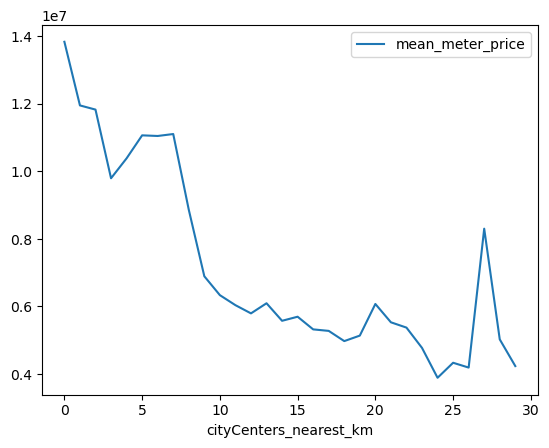

In [142]:
data_price_km.plot(y='mean_meter_price')

Как видно из графика, цена падает с удалением от центра. На графике есть резкие скачки вверх, но они чаще связаны с маленькой выборкой. Однако на 3км от центра цена значительно ниже, чем на соседних км, при нормальном размере выборки. Это может быть связано с районом, в котором находятся эти квартиры.

### Общий вывод

Задачей данной работы является предобработка данных и изучение их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

Сначала мы заполнили пропуски в данных там, где это было возможно. Изменили типы данных на подходящие. Избавились от дубликатов. Устранили выбросы в данных.

Затем добавили в таблицу новые столбцы (день, месяц, год публикации объявления; средняя цена 1 кв.м.; разделили этажи на 3 категории (первый, последний, другой).

После этого изучили данные в уже подготовленном датасете и провели анализ:
* выяснили, как быстро продаются квартиры;
* выявили факторы, влияющие на стоимость;

Из факторов, влияющих на стоимость, следует выделить:
* площадь квартиры (чем она больше, тем и стоимость будет больше);
* жилая площадь;
* площадь кухни;
* количество комнат (чем больше комнат - тем дороже квартира);
* вылияние типа этажа (на первом этаже квартиры будут дешевле всего, на последнем подороже, а самые дорогие - на остальных этажах)

Стоит отметить, что дата размещения объявления не влияет на стоимость квартиры.

Далее посчитали среднюю цену одного квадратного метра в топ 10 населенных пунктах по количеству объявлений. Выяснилось, что дороже всего квадратный метр в Санкт-Петербурге, а дешевле всего, причем почти в 2 раза, в Выборге.

Посчитали среднюю стоимость квадратного метра квартиры на каждый километр удаления от центра. Цена с каждым км будет падать, за исключением района на 3км от центра.